## Notebook 4 - Evaluating our GOES cloud thresholding

To test how well the thresholding is working from GOES radiances/brightnesses, let's pull the pixel for Kettle Ponds and compare to observed radiative fluxes for the SAIL/SPLASH/SoS site.

#### Sections:
1 - Comparison to incoming shortwave from UW tower

2 - Comparison to total sky imager

3 - Try random forest to determine RGB thresholds

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Part 1

#### Load in in situ obs and processed GOES RGB composite

In [36]:
obs

<xarray.Dataset> Size: 1MB
Dimensions:                    (sites: 4, time: 288)
Coordinates:
  * sites                      (sites) |S2 8B b'd' b'ue' b'uw' b'c'
  * time                       (time) datetime64[ns] 2kB 2023-06-05T00:02:30 ...
Data variables: (12/1108)
    latitude_d                 float64 8B ...
    longitude_d                float64 8B ...
    altitude_d                 float64 8B ...
    latitude_ue                float64 8B ...
    longitude_ue               float64 8B ...
    altitude_ue                float64 8B ...
    ...                         ...
    Status_Tint_p3_c           (time) float32 1kB ...
    Status_1_p4_c              (time) float32 1kB ...
    Status_2_p4_c              (time) float32 1kB ...
    Status_3_p4_c              (time) float32 1kB ...
    Status_4_p4_c              (time) float32 1kB ...
    Status_Tint_p4_c           (time) float32 1kB ...
Attributes:
    project:                   SOS
    history:                   Created: 2024-11-18 22:12:45 +0000\n
    NIDAS_version:             v1.2.3-115
    calibration_file_path:     /h/eol/isfs/isfs/projects/SOS/ISFS/cal_files/$...
    project_config:            /h/eol/isfs/isfs/projects/SOS/ISFS/config/sos.xml
    wind3d_horiz_coordinates:  geographic
    file_length_seconds:       86400
    wind3d_horiz_rotation:     1
    wind3d_tilt_correction:    1

In [37]:
date = '20230605'

# In situ obs load
obs_path = '/storage/cdalden/goes/surface_obs/'
obs_file = f'isfs_sos_qc_geo_tiltcor_5min_v2_{date}.nc'
obs = xr.open_dataset(obs_path + obs_file)
# Convert the 'time' coordinate to a pandas.DatetimeIndex
obs['time'] = pd.to_datetime(obs['time'].values)

# Localize the time to UTC and convert to MDT
obs = obs.assign_coords(
    time=pd.to_datetime(obs['time'].values).tz_localize('UTC').tz_convert('America/Denver')
)

# GOES data load
goes_path = '/storage/cdalden/goes/goes16/rgb_composite/'
goes_file = f'goes16_C02_C05_C13_RGB_colorado_{date}.nc'

# Use f-string to dynamically name the dataset
goes_ds_name = f'goes_{date}'
globals()[goes_ds_name] = xr.open_dataset(goes_path + goes_file)

# Access the dataset
# goes_20230605


TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

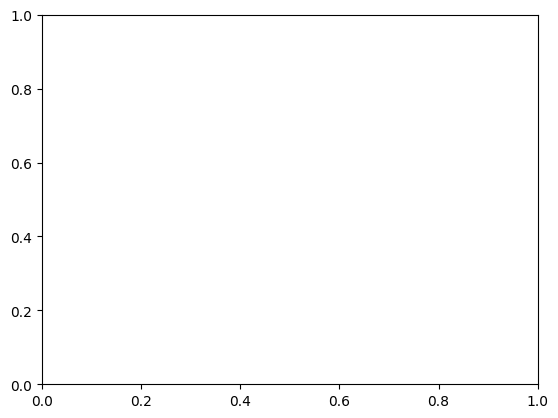

In [38]:
obs['Rsw_in_uw'].plot()

In [39]:
latitude = obs.latitude_uw.values
longitude = obs.longitude_uw.values
goes_crested_butte_pixel = globals()[goes_ds_name].sel(y=latitude, x=longitude, method='nearest')


TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

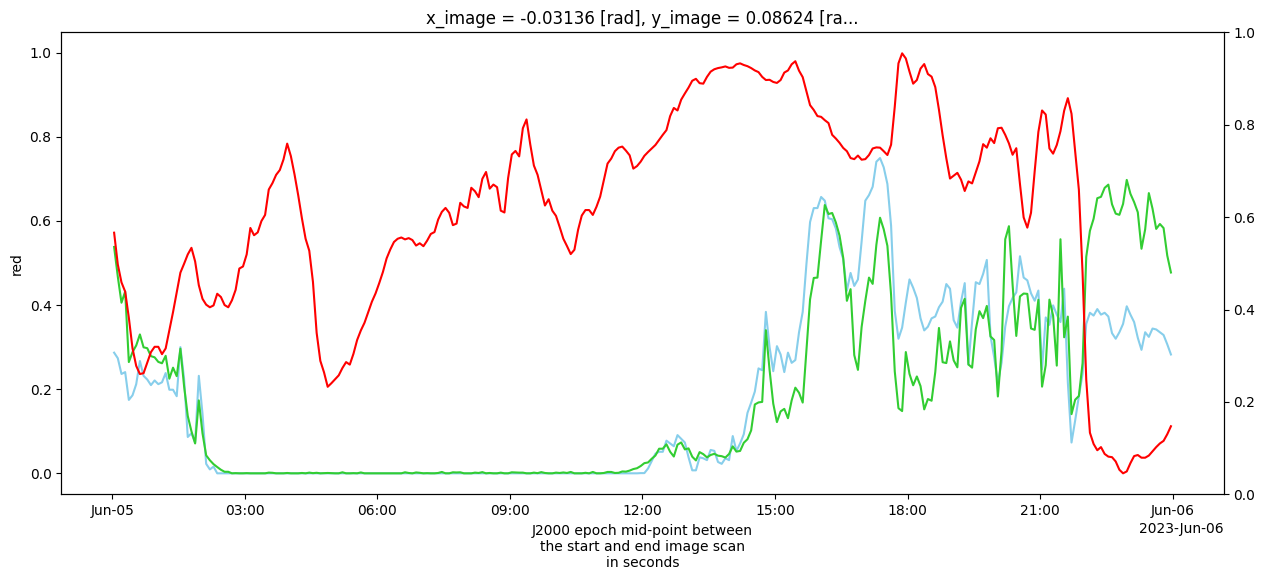

In [40]:
# Plot the GOES data for the specific pixel
fig, ax = plt.subplots(figsize=(15, 6))
goes_crested_butte_pixel['blue'].plot(ax=ax, label='Blue Channel', color='skyblue')
goes_crested_butte_pixel['green'].plot(ax=ax, label='Green Channel', color='limegreen')
goes_crested_butte_pixel['red'].plot(ax=ax, label='Red Channel', color='red')

ax2 = ax.twinx()
obs['Rsw_in_uw'].plot(ax=ax2, 
                             color='black', label='In Situ Shortwave In', ls = '--')


ax.set_xlabel('Time')
ax.set_ylabel('RGB Normalized values')
ax.set_title('GOES RGB Composite and In Situ Shortwave Radiation')
ax.legend()

plt.tight_layout()
plt.savefig(f'./plots/goes_rgb_kettle_ponds_comparison_{date}.png', dpi=300)

## Part 2
### Comparison to total sky imager

In [44]:
tsi_path = '/storage/cdalden/goes/surface_obs/total_sky_imager/'
tsi_file = f'guctsiskycoverM1.b1.{date}.000000.cdf'
tsi = xr.open_dataset(tsi_path + tsi_file)

In [45]:
tsi

<xarray.Dataset> Size: 372kB
Dimensions:                         (time: 1754)
Coordinates:
  * time                            (time) datetime64[ns] 14kB 2023-06-05 ......
Data variables: (12/52)
    base_time                       datetime64[ns] 8B ...
    time_offset                     (time) datetime64[ns] 14kB ...
    qc_time                         (time) int32 7kB ...
    percent_opaque                  (time) float32 7kB ...
    qc_percent_opaque               (time) int32 7kB ...
    percent_thin                    (time) float32 7kB ...
    ...                              ...
    qc_count_mask                   (time) int32 7kB ...
    count_sub_horz                  (time) float32 7kB ...
    qc_count_sub_horz               (time) int32 7kB ...
    lat                             float32 4B ...
    lon                             float32 4B ...
    alt                             float32 4B ...
Attributes: (12/69)
    command_line:                 tsi_ingest -s guc -f M1
    process_version:              ingest-tsi-12.8-5.el7
    dod_version:                  tsiskycover-b1-3.2
    site_id:                      guc
    facility_id:                  M1: Mt Crested Butte, Colorado
    data_level:                   b1
    ...                           ...
    qc_bit_2_description:         Value is less than the valid_min.
    qc_bit_2_assessment:          Bad
    qc_bit_3_description:         Value is greater than the valid_max.
    qc_bit_3_assessment:          Bad
    datastream:                   guctsiskycoverM1.b1
    history:                      created by user dsmgr on machine prod-proc2...

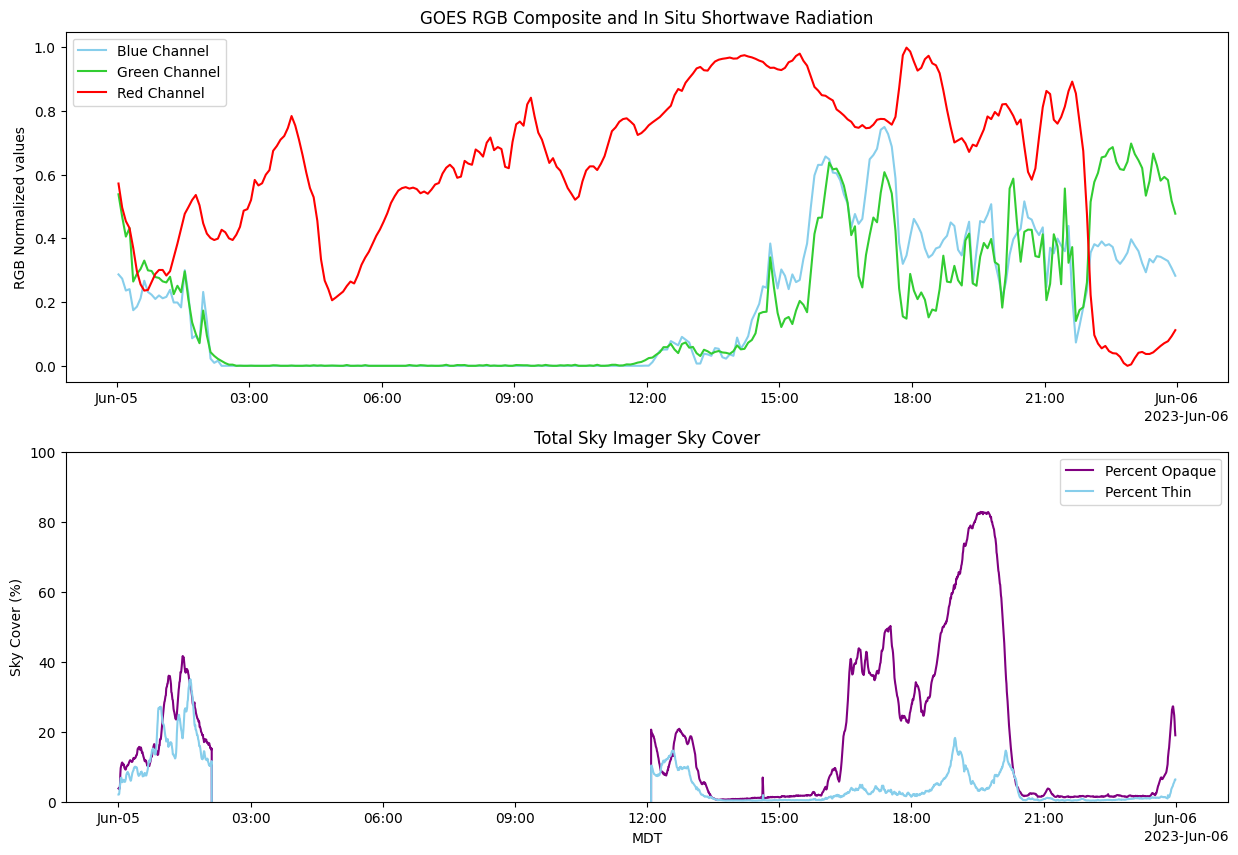

In [48]:
fig, ax = plt.subplots(2,1,figsize=(15, 10))

# Plot the GOES data for the specific pixel
goes_crested_butte_pixel['blue'].plot(ax=ax[0], label='Blue Channel', color='skyblue')
goes_crested_butte_pixel['green'].plot(ax=ax[0], label='Green Channel', color='limegreen')
goes_crested_butte_pixel['red'].plot(ax=ax[0], label='Red Channel', color='red')

ax[0].set_xlabel('')
ax[0].set_ylabel('RGB Normalized values')
ax[0].set_title('GOES RGB Composite and In Situ Shortwave Radiation')
# ax[0].set_xlim(pd.to_datetime('2023-06-05T12:00:00'), pd.to_datetime('2023-06-06T00:00:00'))
ax[0].legend()


# Plot the total sky imager data
tsi['percent_opaque'].plot(ax=ax[1], color='purple', label='Percent Opaque')
tsi['percent_thin'].plot(ax=ax[1], color='skyblue', label='Percent Thin')
# tsi['sunny'].plot(ax=ax[1], color='orange', label='Sunny') # this is just a binary sun/no sun class

ax[1].set_xlabel('MDT')
ax[1].set_ylabel('Sky Cover (%)')
ax[1].set_title('Total Sky Imager Sky Cover')
ax[1].set_ylim(0, 100)
ax[1].legend()

## Part 3
### Random Forest to determine thresholds

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report